In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.linalg
from math import sqrt

from problem import ElecVehCharg
from algorithms import UDC
import networkx as nx
import matplotlib.pyplot as plt
from plot_utils import MyFigure, MyFigureThree

# Set up the logger to print info messages for understandability.
import logging
import sys
import os
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

import json

d:\OneDrive\OneDrive - shanghaitech.edu.cn\Research\Dual AMM\numerical\exp4_graph_weights\algorithms\Liu25_UDC.py:253: SyntaxWarning: invalid escape sequence '\m'
  Ay_\mu^k - \tilde{H}^{1/2}z_\mu^k


Text(0.5, 1.0, '2 cliques')

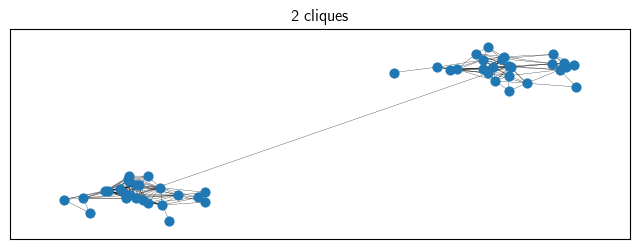

In [2]:
# read network graphs

N = 50  # num of nodes

graph_dir = 'graphs'
graph_names = [
    'complete_graph',
    'erdos_renyi_graph',
    'geometric_random_graph',
    '2_cliques',
    'ring_graph',
    'spanning_tree'
]
graphs = {}

for name in graph_names:
    with open(f'{graph_dir}/{name}.json') as f:
        data = json.load(f)
        graphs[name] = nx.node_link_graph(data, edges="links")

# test data
name = '2_cliques'
G = graphs[name]
nodes_data = G.nodes.data()
pos = {i: nodes_data[i]['pos'] for i in range(N)}

options = {
    # 'node_color': 'black',
    # 'arrowsize': 3,
    'node_size': 50,
    'width': 0.2,
    'linewidths': 0.2,
    'with_labels': False,
}

subax1 = plt.subplot(211)
nx.draw_networkx(G, pos=pos, **options)
subax1.set_title(name.replace('_', ' '))

In [13]:
# generate problem data
# N = 50
prob = ElecVehCharg(N)
# prob = Synthetic(parameters, debug=True)

prob.gen()
prob.load()
# print(f'x* {prob.x_star}')
print(f'||x*|| {np.linalg.norm(prob.x_star)}')

# g = prob.opt_cons_vio
# Mg = np.identity(num_node) - network
# g_in_Null_H = sqrt(g.T @ Mg @ g)
# g_norm = np.linalg.norm(g)
# print(f'||tilg(x*)|| {g_norm}')
# print(f'1 - ||tilg(x*)||_H / ||tilg(x*)|| {1-g_in_Null_H/g_norm}\n')

generating a ElecVehCharg problem, N=50
x* [ 1.05e-11 -2.81e-13  1.57e-10  1.34e-01  1.00e+00  1.00e+00  4.11e-11
  1.00e+00  1.44e-11  2.08e-11  1.82e-11 -2.95e-12  7.93e-11  2.41e-01
  6.02e-01  1.00e+00  7.16e-13  7.53e-11  2.46e-11 -1.57e-12  2.21e-01
 -4.09e-12  3.07e-02  8.66e-01  1.83e-02  1.91e-01  1.00e+00  1.00e+00
  3.73e-12 -5.50e-13  3.41e-11  8.72e-12  4.35e-12  9.60e-02  2.00e-02
  1.00e+00  6.80e-11  1.68e-11  8.81e-11  5.56e-11  7.58e-12  2.72e-11
  1.09e-10  2.23e-11  1.00e+00  1.00e-11  5.17e-11  7.23e-02  4.08e-12
  1.17e-01], f* 2.1073939612320154
generated problem saved in problem_data/N50
loading a ElecVehCharg problem, N=50
problem loaded:
c (50,)
d (50,)
b (1,)
x_star (50,)
opt_val 2.1073939612320154
||x*|| 3.050188293502867


In [14]:
# # load instance 1
N = 50
instance_name = 'instance1_N50'
instance_dir = 'problem_data/' + instance_name

# problem data
prob = ElecVehCharg(N)
prob.save_dir = instance_dir
prob.load()

print(f'x* {prob.x_star}')
print(f'||x*|| {np.linalg.norm(prob.x_star)}\n')

# network adjacency matrices
networks = {}
for name, G in graphs.items():
    networks[name] = nx.to_numpy_array(G)
    
print(networks['2_cliques'].shape)


loading a ElecVehCharg problem, N=50
problem loaded:
c (50,)
d (50,)
b (1,)
x_star (50,)
opt_val 1.209571107526383
x* [-2.11e-12  1.29e-11  1.39e-12  2.43e-11  4.16e-11  7.56e-10  4.32e-12
  7.07e-12  5.83e-01  1.59e-11 -3.37e-12  1.00e+00  5.26e-11  4.14e-11
  3.53e-14 -4.03e-12  6.13e-01  1.17e-12  5.56e-11  1.44e-11  8.75e-12
  3.23e-01  1.00e+00  2.61e-10  1.63e-11  1.63e-10  1.00e+00  9.95e-05
  6.42e-11  1.00e+00  4.46e-11  1.13e-10  2.89e-11  1.00e+00  1.00e+00
  1.00e+00  3.12e-11  5.41e-01  4.49e-01  2.94e-11 -3.98e-13 -6.33e-12
  4.14e-11  2.37e-11  1.74e-10  2.03e-01  9.23e-11  4.75e-11  3.03e-01
  8.10e-13]
||x*|| 2.9064216087874417

(50, 50)


In [15]:
# prepare figures

figures = MyFigureThree()

log_dir = 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
np.set_printoptions(formatter={'float':lambda x: f' {x:.2e}' if x>0 else f'{x:.2e}'})

In [19]:
# UDC

# best parameters (for 120 edge graph):
# PEXTRA: r1
# PGC: r0.1
# D.A.: 0.5
# ALT: 2

MAX_ITER = 500
# MAX_ITER = 1000
# MAX_ITER = 2000

# rho_choice = [0.1, 1, 10, 100]
# rho_choice = [0.5, 1, 2, 4]
# rho_choice = [0.25, 0.5]
rho_choice = [1]
# rho_choice = [0.1]

figures.clear()

graph_name = 'erdos_renyi_graph'
graph_adj = networks[graph_name]
param_settings = ['PEXTRA', 'PGC', 'DPGA', 'DistADMM', 'ALT']
param_setting = param_settings[0]
log_dir = f'log/{graph_name}'

rho = 1
alg = UDC(prob, log_dir, graph_adj, rho=rho, alpha=0,
            param_setting=param_setting, verbose=False)
for i in range(MAX_ITER):
    alg.step()

# save convergence plot from files    
log_prefix = f'{alg.name}_a{0}_r{rho}'
figures.add_lines(graph_name, log_prefix)
figures.paint(MAX_ITER=MAX_ITER)

UDC setting: PEXTRA
d: (50,)
reset
UDC_PEXTRA alpha 0 rho 1, iter 0, obj err: 1.21e+00, cons vio: 5.00e+00
time 0.02, saved



C:\Users\Lilith\AppData\Roaming\Python\Python313\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


UDC_PEXTRA alpha 0 rho 1, iter 100, obj err: 2.92e-03, cons vio: 0.00e+00
time 1.85, saved

UDC_PEXTRA alpha 0 rho 1, iter 200, obj err: 5.25e-05, cons vio: 8.81e-05
time 3.20, saved

UDC_PEXTRA alpha 0 rho 1, iter 300, obj err: 7.37e-06, cons vio: 0.00e+00
time 4.26, saved

UDC_PEXTRA alpha 0 rho 1, iter 400, obj err: 2.74e-07, cons vio: 4.60e-07
time 5.78, saved

UDC_PEXTRA alpha 0 rho 1, iter 500, obj err: 4.44e-08, cons vio: 7.45e-08
time 6.93, saved



In [61]:
# UDC, finetune rho

# best parameters 
# instance 1, for 120 edge graph:
# PEXTRA: r1
# PGC: r0.1
# DPGA: r0.1
# D.A.: 0.5
# ALT: 2

# instance 2, 120 edge, identical constraints
# PEXTRA: r2
# PGC: r0.2
# DPGA: r0.1
# D.A.: 4
# ALT: 8 

# MAX_ITER = 500
# MAX_ITER = 2000
MAX_ITER = 10000

log_dir = 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# rho_choice = [0.1, 1, 10]
# rho_choice = [0.5, 1, 2, 4, 8, 16]
# rho_choice = [1, 2, 4]
# rho_choice = [0.05, 0.1, 0.2]
rho_choice = [0.1]

# alpha_choice = [0, 10, 100]
# alpha_choice = [0, 0.1]
alpha_choice = [0]

color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
linestyle = ['-', '--', '-.', ':', '']

obj_err_figure = MyFigure(filename='obj_err', 
                            xlabel=r'$\mathrm{iteration}$ $k$', 
                            ylabel='objective error',
                            yscale='log')
cons_vio_figure = MyFigure(filename='cons_vio', 
                            xlabel=r'$\mathrm{iteration}$ $k$', 
                            ylabel='constraint violation',
                            yscale='log')
x_dis_figure = MyFigure(filename='x_distance', 
                            xlabel=r'$\mathrm{iteration}$ $k$', 
                            ylabel='x distance',
                            yscale='log')
    
np.set_printoptions(formatter={'float':lambda x: f' {x:.2e}' if x>0 else f'{x:.2e}'})
for alpha in alpha_choice:
    for rho in rho_choice:
        # ci = alpha_choice.index(alpha)
        # lsi = rho_choice.index(rho)
        ci = rho_choice.index(rho)
        lsi = alpha_choice.index(alpha)
        c = color[ci]
        ls = linestyle[lsi]
        
        if False:
        # if alpha != 0:
        # if rho != 0.1:
        # if rho == 16:
            # alg = UDC(prob, network, rho=rho, alpha=alpha,
            #           param_setting='PEXTRA', verbose=False)
            # alg = UDC(prob, network, rho=rho, alpha=alpha,
            #           param_setting='PGC', verbose=False)
            # alg = UDC(prob, network, rho=rho, alpha=alpha,
            #           param_setting='DPGA', verbose=False)
            alg = UDC(prob, network, rho=rho, alpha=alpha,
                      param_setting='DistADMM', verbose=False)
            # alg = UDC(prob, network, rho=rho, alpha=alpha,
            #         param_setting='ALT', verbose=False)
            for i in range(MAX_ITER):
                alg.step()
            
        prefix = f'{alg.name}_a{alpha}_r{rho}'
        # filename_oe = f'log/N{num_node}/{prefix}_oe.txt'
        # filename_cv = f'log/N{num_node}/{prefix}_cv.txt'
        # filename_xd = f'log/N{num_node}/{prefix}_xd.txt'
        filename_oe = f'log/N{num_node}/{prefix}_oe_avg.txt'
        filename_cv = f'log/N{num_node}/{prefix}_cv_avg.txt'
        filename_xd = f'log/N{num_node}/{prefix}_xd_avg.txt'
        
        obj_err_figure.add_line_file(prefix, filename_oe, style=c+ls)
        cons_vio_figure.add_line_file(prefix, filename_cv, style=c+ls)
        x_dis_figure.add_line_file(prefix, filename_xd, style=c+ls)
            
        obj_err_figure.paint(MAX_ITER=MAX_ITER)
        cons_vio_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
        x_dis_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)


In [12]:
# load best params
# instance 2, 120 edge, identical constraints

# PEXTRA: r2
# PGC: r0.2
# DPGA: r0.1
# D.A.: 4
# ALT: 8 

# running avg: all of them performs better (cons vio) with smaller rho

alg_list = []
alg_list.append(UDC(prob, network, alpha=0, rho=2, param_setting='PEXTRA'))
alg_list.append(UDC(prob, network, alpha=0, rho=0.2, param_setting='PGC'))
alg_list.append(UDC(prob, network, alpha=0, rho=0.1, param_setting='DPGA'))
alg_list.append(UDC(prob, network, alpha=0, rho=4, param_setting='DistADMM'))
alg_list.append(UDC(prob, network, alpha=0, rho=8, param_setting='ALT'))
oe_logs = dict()
cv_logs = dict()
xd_logs = dict()


color = ['tab:green', 'chocolate', 'red', 'chartreuse', 'navy', 'grey', 'k', 'crimson']
marker = ['.', 'o', 'v', '^', '8', 's', '*', 'd', 'X']
MAX_ITER = 2000

obj_err_figure = MyFigure(filename='compare_obj_err', 
                            xlabel=r'$\mathrm{Iteration}$ $k$', 
                            ylabel=r'$\mathrm{Objective}\ \mathrm{Error}$')

cons_vio_figure = MyFigure(filename='compare_cons_vio', 
                            xlabel=r'$\mathrm{Iteration}$ $k$', 
                            ylabel=r'$\mathrm{Constraint}\ \mathrm{Violation}$')

x_dis_figure = MyFigure(filename='compare_x_distance', 
                            xlabel=r'$\mathrm{Iteration}$ $k$', 
                            ylabel=r'$\Vert \mathbf{x}^k - \mathbf{x}^\star \Vert$')

for alg in alg_list:
    # instance 2
    log_dir = f'instance/instance2_identical_cons/log'
    file_alg_name = alg.name.replace(' ', '_').replace('-', '_')
    # filename_oe = f'{log_dir}/{file_alg_name}/{alg.file_prefix}_oe_avg.txt'
    # filename_cv = f'{log_dir}/{file_alg_name}/{alg.file_prefix}_cv_avg.txt'
    # filename_xd = f'{log_dir}/{file_alg_name}/{alg.file_prefix}_xd_avg.txt'
    filename_oe = f'{log_dir}/{file_alg_name}/{alg.file_prefix}_oe.txt'
    filename_cv = f'{log_dir}/{file_alg_name}/{alg.file_prefix}_cv.txt'
    filename_xd = f'{log_dir}/{file_alg_name}/{alg.file_prefix}_xd.txt'
    oe_logs[alg.name] = np.loadtxt(filename_oe)
    cv_logs[alg.name] = np.loadtxt(filename_cv)
    xd_logs[alg.name] = np.loadtxt(filename_xd)

UDC setting: PEXTRA
d: (100,)
reset
UDC_PEXTRA alpha 0 rho 2, iter 0, obj err: 4.24e+00, cons vio: 1.00e+01
time 0.00, saved

UDC setting: PGC
d: (100,)
reset
UDC_PGC alpha 0 rho 0.2, iter 0, obj err: 4.24e+00, cons vio: 1.00e+01
time 0.01, saved

UDC setting: DPGA
d: (100,)
reset
UDC_DPGA alpha 0 rho 0.1, iter 0, obj err: 4.24e+00, cons vio: 1.00e+01
time 0.02, saved

UDC setting: DistADMM
d: (100,)
reset
UDC_DistADMM alpha 0 rho 4, iter 0, obj err: 4.24e+00, cons vio: 1.00e+01
time 0.01, saved

UDC setting: ALT
d: (100,)
reset
ALT alpha 0 rho 8, iter 0, obj err: 4.24e+00, cons vio: 1.00e+01
time 0.01, saved



In [10]:
from scipy.linalg import eigvalsh
from math import sqrt

for alg in alg_list:
    print(alg.name)
    A, H1, H2, D = alg.A_weight, alg.H1, alg.H2, alg.D
    rho = 1.0 if alg.rho_only_in_mat else alg.rho
    A_max = eigvalsh(A)[-1]
    tilH_min2 = eigvalsh(H2)[1]
    # print(f'A_max: {A_max}')
    # print(f'tilH eigen min2: {tilH_min2}')
    # print(f'rho: {rho}')
    # print(f'rho * tilH_min2: {rho*eigvalsh(H2)[1]}')
    print(f'coeff in OE: {1/(rho*tilH_min2)}')
    print(f'coeff in FE: {A_max}, {1/rho*sqrt(A_max/tilH_min2)}')
    print()

UDC_PEXTRA
coeff in OE: 74.64816529848297
coeff in FE: 2.0, 8.639916972892909

UDC_PGC
coeff in OE: 72.11670230103077
coeff in FE: 1.8743385527191645, 11.626311341857006

UDC_DPGA
coeff in OE: 99.92783396776706
coeff in FE: 1.352687334956129, 11.626311341857201

UDC_DistADMM
coeff in OE: 1393.0871456071372
coeff in FE: 26.571990152851505, 96.19913969877389

ALT
coeff in OE: 696.5435728035686
coeff in FE: 8.000000000000004, 26.392111942843243



In [13]:

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
from matplotlib.ticker import FormatStrFormatter, LogFormatter
from matplotlib.legend_handler import HandlerTuple
# rc('mathtext', fontset='stixsans')
# rc('text', usetex=True)
# rc('text', usetex=True)
# rc('mathtext', fontset ='dejavusans')
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['DejaVu Sans'], 'size': 40})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": "Computer Modern Roman",
    "font.sans-serif": "Helvetica",
    "font.size": 42,
    'text.latex.preamble': r'\usepackage{sfmath}' # sans-serif for math
})

fig, ax = plt.subplots(figsize=(20, 12))   
ax.set_xlim(0, MAX_ITER)
ax.set_yscale('log')
ax.set_xlabel(r'Iteration $k$', fontsize=42)
ax.set_ylabel(r'Objective Error', fontsize=42)
ax.tick_params(axis='both', labelsize=42)
ax.yaxis.set_minor_locator(plt.LogLocator())
ax.spines.bottom.set_linewidth(2)
ax.spines.top.set_linewidth(2)
ax.spines.left.set_linewidth(2)
ax.spines.right.set_linewidth(2)
plt.grid(True, ls="--", color='0.65')


p1, = ax.plot(oe_logs['UDC_PEXTRA'], label='UDC-PEXTRA', lw=3, c='xkcd:blue')
p2, = ax.plot(oe_logs['UDC_PGC'], lw=3, c='#00BFFF', label='UDC-PGC',alpha=0.5) # , label='UDC-PGC' sky blue
p3, = ax.plot(oe_logs['UDC_DPGA'], lw=3, c='#6699CC', label='UDC-DPGA',alpha=0.4) # , label='UDC-DPGA' blue gray
p4, = ax.plot(oe_logs['UDC_DistADMM'], label='UDC-Dist.ADMM', ls='-', c='xkcd:green',lw=3)
p5, = ax.plot(oe_logs['ALT'], label='ALT', ls='-', lw=3, c='xkcd:orangered')

ax.legend(fontsize=40)
fig.savefig(f'compare_obj_err.pdf', bbox_inches='tight', transparent=False)




fig, ax = plt.subplots(figsize=(20, 12))   
ax.set_xlim(0, MAX_ITER)
ax.set_yscale('log')
ax.set_xlabel(r'Iteration $k$', fontsize=42)
ax.set_ylabel(r'Constraint Violation', fontsize=42)
ax.tick_params(axis='both', labelsize=42)
ax.yaxis.set_minor_locator(plt.LogLocator())
ax.spines.bottom.set_linewidth(2)
ax.spines.top.set_linewidth(2)
ax.spines.left.set_linewidth(2)
ax.spines.right.set_linewidth(2)
plt.grid(True, ls="--", color='0.65')


p1, = ax.plot(cv_logs['UDC_PEXTRA'], label='UDC-PEXTRA', lw=3, c='xkcd:blue')
p2, = ax.plot(cv_logs['UDC_PGC'], lw=3, c='#00BFFF', label='UDC-PGC',alpha=0.5) # , label='UDC-PGC' sky blue
p3, = ax.plot(cv_logs['UDC_DPGA'], lw=3, c='#6699CC', label='UDC-DPGA',alpha=0.4) # , label='UDC-DPGA' blue gray
p4, = ax.plot(cv_logs['UDC_DistADMM'], label='UDC-Dist.ADMM', ls='-', c='xkcd:green',lw=3)
p5, = ax.plot(cv_logs['ALT'], label='ALT', ls='-', lw=3, c='xkcd:orangered')

ax.legend(fontsize=40)
fig.savefig(f'compare_cons_vio.pdf', bbox_inches='tight', transparent=False)


In [ ]:
# UDC
# effect of alpha

# best parameters 
# instance 1, for 120 edge graph:
# PEXTRA: r1
# PGC: r0.1
# DPGA: r0.1
# D.A.: 0.5
# ALT: 2

# instance 2, 120 edge, identical constraints
# PEXTRA: r1
# PGC: r0.1
# DPGA: r0.1
# D.A.: 0.5
# ALT: 2 


MAX_ITER = 500
# MAX_ITER = 1000
# MAX_ITER = 2000

log_dir = 'log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# num_edge_list = [50, 60, 90, 120, 200, 500, 1000]
num_edge = 120

rho_choice = [0.1, 1, 10, 100]
# rho_choice = [0.5, 1, 2, 4]
# rho_choice = [0.25, 0.5]
# rho_choice = [1]
# rho_choice = [0.05, 0.1, 0.2]
# alpha_choice = [0, 0.1, 1]
alpha_choice = [0.2, 2]

color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
linestyle = ['-', '--', '-.', ':', '']
al_list = [0.2, 0.5, 1]

obj_err_figure = MyFigure(filename='obj_err', 
                            xlabel=r'$\mathrm{iteration}$ $k$', 
                            ylabel='objective error',
                            yscale='log')
cons_vio_figure = MyFigure(filename='cons_vio', 
                            xlabel=r'$\mathrm{iteration}$ $k$', 
                            ylabel='constraint violation',
                            yscale='log')
x_dis_figure = MyFigure(filename='x_distance', 
                            xlabel=r'$\mathrm{iteration}$ $k$', 
                            ylabel='x distance',
                            yscale='log')
    
np.set_printoptions(formatter={'float':lambda x: f' {x:.2e}' if x>0 else f'{x:.2e}'})

# for num_edge in num_edge_list:
# for rho in rho_choice:
for alpha in alpha_choice:
    network = np.load(f'instance/graph/N50E{num_edge}/subgraph_W.npy')
    
    ali = alpha_choice.index(alpha)
    al = al_list[ali]
    
    c = color[1]
    rho = 1
    alg = UDC(prob, network, rho=rho, alpha=alpha,
                    param_setting='PEXTRA', verbose=False)
    for i in range(MAX_ITER):
        alg.step()
        
    prefix = f'{alg.name}_a{alpha}_r{rho}'
    filename_oe = f'log/N{num_node}/{prefix}_oe.txt'
    filename_cv = f'log/N{num_node}/{prefix}_cv.txt'
    filename_xd = f'log/N{num_node}/{prefix}_xd.txt'
    
    obj_err_figure.add_line_file(f'PEXTRA_r{rho}_a{alpha}', filename_oe, style=c, alpha=al)
    cons_vio_figure.add_line_file(f'PEXTRA_r{rho}_a{alpha}', filename_cv, style=c, alpha=al)
    x_dis_figure.add_line_file(f'PEXTRA_r{rho}_a{alpha}', filename_xd, style=c, alpha=al)
        
    obj_err_figure.paint(MAX_ITER=MAX_ITER)
    cons_vio_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
    x_dis_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
    
    
    
    c = color[2]
    rho =0.1
    alg = UDC(prob, network, rho=rho, alpha=alpha,
                    param_setting='PGC', verbose=False)
    for i in range(MAX_ITER):
        alg.step()
        
    prefix = f'{alg.name}_a{alpha}_r{rho}'
    filename_oe = f'log/N{num_node}/{prefix}_oe.txt'
    filename_cv = f'log/N{num_node}/{prefix}_cv.txt'
    filename_xd = f'log/N{num_node}/{prefix}_xd.txt'
    obj_err_figure.add_line_file(f'PGC_r{rho}_a{alpha}', filename_oe, style=c, alpha=al)
    cons_vio_figure.add_line_file(f'PGC_r{rho}_a{alpha}', filename_cv, style=c, alpha=al)
    x_dis_figure.add_line_file(f'PGC_r{rho}_a{alpha}', filename_xd, style=c, alpha=al)
    obj_err_figure.paint(MAX_ITER=MAX_ITER)
    cons_vio_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
    x_dis_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)


    c = color[3]
    rho =0.1
    alg = UDC(prob, network, rho=rho, alpha=alpha,
                  param_setting='DPGA', verbose=False)
    for i in range(MAX_ITER):
        alg.step()
        
    prefix = f'{alg.name}_a{alpha}_r{rho}'
    filename_oe = f'log/N{num_node}/{prefix}_oe.txt'
    filename_cv = f'log/N{num_node}/{prefix}_cv.txt'
    filename_xd = f'log/N{num_node}/{prefix}_xd.txt'
    obj_err_figure.add_line_file(f'DPGA_r{rho}_a{alpha}', filename_oe, style=c, alpha=al)
    cons_vio_figure.add_line_file(f'DPGA_r{rho}_a{alpha}', filename_cv, style=c, alpha=al)
    x_dis_figure.add_line_file(f'DPGA_r{rho}_a{alpha}', filename_xd, style=c, alpha=al)
    obj_err_figure.paint(MAX_ITER=MAX_ITER)
    cons_vio_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
    x_dis_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)


    c = color[4]
    rho =0.5
    alg = UDC(prob, network, rho=0.5, alpha=alpha,
                    param_setting='DistADMM', verbose=False)
    for i in range(MAX_ITER):
        alg.step()
        
    prefix = f'{alg.name}_a{alpha}_r{rho}'
    filename_oe = f'log/N{num_node}/{prefix}_oe.txt'
    filename_cv = f'log/N{num_node}/{prefix}_cv.txt'
    filename_xd = f'log/N{num_node}/{prefix}_xd.txt'
    obj_err_figure.add_line_file(f'D.A._r{rho}_a{alpha}', filename_oe, style=c, alpha=al)
    cons_vio_figure.add_line_file(f'D.A._r{rho}_a{alpha}', filename_cv, style=c, alpha=al)
    x_dis_figure.add_line_file(f'D.A._r{rho}_a{alpha}', filename_xd, style=c, alpha=al)
    obj_err_figure.paint(MAX_ITER=MAX_ITER)
    cons_vio_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
    x_dis_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
    
    
    
    c = color[5]
    rho = 2
    alg = UDC(prob, network, rho=rho, alpha=alpha,
                param_setting='ALT', verbose=False)
    for i in range(MAX_ITER):
        alg.step()
        
    prefix = f'{alg.name}_a{alpha}_r{rho}'
    filename_oe = f'log/N{num_node}/{prefix}_oe.txt'
    filename_cv = f'log/N{num_node}/{prefix}_cv.txt'
    filename_xd = f'log/N{num_node}/{prefix}_xd.txt'
    obj_err_figure.add_line_file(f'ALT_r{rho}_a{alpha}', filename_oe, style=c, alpha=al)
    cons_vio_figure.add_line_file(f'ALT_r{rho}_a{alpha}', filename_cv, style=c, alpha=al)
    x_dis_figure.add_line_file(f'ALT_r{rho}_a{alpha}', filename_xd, style=c, alpha=al)
    obj_err_figure.paint(MAX_ITER=MAX_ITER)
    cons_vio_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)
    x_dis_figure.paint(MAX_ITER=MAX_ITER, nonnegy=True)

UDC setting: PEXTRA
d: (50,)
reset
UDC_PEXTRA alpha 0.2 rho 1, iter 0, obj err: 1.80e+00, cons vio: 5.00e+00
time 0.02, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 100, obj err: 6.62e-05, cons vio: 0.00e+00
time 0.72, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 200, obj err: 1.89e-07, cons vio: 3.45e-07
time 1.38, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 300, obj err: 1.39e-08, cons vio: 0.00e+00
time 2.03, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 400, obj err: 1.33e-08, cons vio: 1.68e-12
time 2.68, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 500, obj err: 1.33e-08, cons vio: 0.00e+00
time 3.25, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 600, obj err: 1.33e-08, cons vio: 5.59e-12
time 3.89, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 700, obj err: 1.33e-08, cons vio: 0.00e+00
time 4.48, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 800, obj err: 1.33e-08, cons vio: 0.00e+00
time 5.09, saved

UDC_PEXTRA alpha 0.2 rho 1, iter 900, obj err: 1.33e-08, cons vio: 0.00e+00
time 5.72, saved

UDC_PEXTRA alpha 0.2 rho 1,

In [139]:
# load log data

# best parameters (for 120 edge graph):
# PEXTRA: r1
# PGC: r0.1
# DPGA: r0.1
# D.A.: r0.5
# ALT: r2

MAX_ITER = 1000
network = np.load(f'instance/graph/N50E{120}/subgraph_W.npy')
log_dir = f'instance/instance1/log'

alpha_choice = [0, 0.1, 0.2, 1, 2]

oe_logs = dict()
cv_logs = dict()
xd_logs = dict()
oe_cv_logs = dict()

for alpha in alpha_choice:
    # xd
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    filename_xd = f'{log_dir}/{alg_param_name}_xd.txt'
    xd_logs[alg_param_name] = np.loadtxt(filename_xd)

    alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    filename_xd = f'{log_dir}/{alg_param_name}_xd.txt'
    xd_logs[alg_param_name] = np.loadtxt(filename_xd)
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    filename_xd = f'{log_dir}/{alg_param_name}_xd.txt'
    xd_logs[alg_param_name] = np.loadtxt(filename_xd)
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    filename_xd = f'{log_dir}/{alg_param_name}_xd.txt'
    xd_logs[alg_param_name] = np.loadtxt(filename_xd)

    # oe
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    oe_logs[alg_param_name] = np.loadtxt(filename_oe)

    alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    oe_logs[alg_param_name] = np.loadtxt(filename_oe)
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    oe_logs[alg_param_name] = np.loadtxt(filename_oe)
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    oe_logs[alg_param_name] = np.loadtxt(filename_oe)
    
    # cv
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    cv_logs[alg_param_name] = np.loadtxt(filename_cv)

    alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    cv_logs[alg_param_name] = np.loadtxt(filename_cv)
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    cv_logs[alg_param_name] = np.loadtxt(filename_cv)
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    cv_logs[alg_param_name] = np.loadtxt(filename_cv)
    
    # oe + cv
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    oe_cv_logs[alg_param_name] = np.loadtxt(filename_oe)+np.loadtxt(filename_cv)

    alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    oe_cv_logs[alg_param_name] = np.loadtxt(filename_oe)+np.loadtxt(filename_cv)
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    oe_cv_logs[alg_param_name] = np.loadtxt(filename_oe)+np.loadtxt(filename_cv)
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    filename_oe = f'{log_dir}/{alg_param_name}_oe.txt'
    filename_cv = f'{log_dir}/{alg_param_name}_cv.txt'
    oe_cv_logs[alg_param_name] = np.loadtxt(filename_oe)+np.loadtxt(filename_cv)

In [169]:
# fig 1: effect of alpha
# subfig: x_distance

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
from matplotlib.ticker import FormatStrFormatter, LogFormatter
from matplotlib.legend_handler import HandlerTuple
# rc('mathtext', fontset='stixsans')
# rc('text', usetex=True)
# rc('text', usetex=True)
# rc('mathtext', fontset ='dejavusans')
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['DejaVu Sans'], 'size': 40})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": "Computer Modern Roman",
    "font.sans-serif": "Helvetica",
    "font.size": 42,
    'text.latex.preamble': r'\usepackage{sfmath}' # sans-serif for math
})


MAX_ITER = 500
fig, ax = plt.subplots(figsize=(20, 12))   
ax.set_xlim(0, MAX_ITER)
ax.set_yscale('log')
ax.set_xlabel(r'Iteration $k$', fontsize=42)
ax.set_ylabel(r'$\Vert x^k-x^\star\Vert$', fontsize=42)
ax.tick_params(axis='both', labelsize=42)
ax.yaxis.set_minor_locator(plt.LogLocator())
ax.spines.bottom.set_linewidth(2)
ax.spines.top.set_linewidth(2)
ax.spines.left.set_linewidth(2)
ax.spines.right.set_linewidth(2)
plt.grid(True, ls="--", color='0.65')


# alpha_choice = [0, 0.1, 0.2, 1, 2]
alpha_choice = [0, 0.2, 2]
darkness = {
        0  : 1,
        0.1: 0.5,
        0.2: 0.5,
        1  : 0.8,
        2  : 1
    }
ls = {
        0  : ':',
        0.1: '-',
        0.2: '-',
        1  : '-',
        2  : '-'
    }
c = {
    
}

p1 = {}
p2 = {}
p3 = {}
p4 = {}
for alpha in alpha_choice:
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    p1[alpha], = ax.plot(xd_logs[alg_param_name], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    c='tab:purple', 
    alpha=darkness[alpha], 
    ls=ls[alpha])
    
    # alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    # p2[alpha], = ax.plot(xd_logs[alg_param_name], label=alg_param_name, 
    # lw=3,
    # # lw = lw[alpha], 
    # c='xkcd:green', 
    # alpha=darkness[alpha], 
    # ls=ls[alpha]) 
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    p3[alpha], = ax.plot(xd_logs[alg_param_name], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    c='tab:blue', 
    alpha=darkness[alpha], 
    ls=ls[alpha]) 
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    p4[alpha], = ax.plot(xd_logs[alg_param_name], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    c='tab:orange', 
    alpha=darkness[alpha], 
    ls=ls[alpha])

# ax.legend([(p1[0], p1[0.1], p1[0.2], p1[1], p1[2]), 
#         #    (p2[0], p2[0.1], p2[0.2], p2[1], p2[2]),
#            (p3[0], p3[0.1], p3[0.2], p3[1], p3[2]),
#            (p4[0], p4[0.1], p4[0.2], p4[1], p4[2])], 
#           ['ProxUDC-PEXTRA', 
#         #    'ProxUDC-PGC', 
#            'ProxUDC-DPGA', 
#            'ProxUDC-ALT'], 
#             handler_map={tuple: HandlerTuple(ndivide=None)},
#             fontsize=40)
ax.legend([ p1[0], p3[0], p4[0],
           (p1[0.2], p1[2]), 
           (p3[0.2], p3[2]),
           (p4[0.2], p4[2])], 
          [ 'UDC-PEXTRA',
            'UDC-DPGA', 
            'UDC-ALT',
            'ProxUDC-PEXTRA', 
            'ProxUDC-DPGA', 
            'ProxUDC-ALT'], 
            handler_map={tuple: HandlerTuple(ndivide=None)},
            fontsize=40)
# ax.legend(fontsize=40)
fig.savefig(f'compare_x_distance.pdf', bbox_inches='tight', transparent=False)




In [170]:
# fig 1: effect of alpha
# subfig: objective error + constraint violation


MAX_ITER = 500
fig, ax = plt.subplots(figsize=(20, 12))   
ax.set_xlim(0, MAX_ITER)
ax.set_yscale('log')
ax.set_xlabel(r'Iteration $k$', fontsize=42)
ax.set_ylabel(r'Objective Error + Constraint Violation', fontsize=42)
ax.tick_params(axis='both', labelsize=42)
ax.yaxis.set_minor_locator(plt.LogLocator())
ax.spines.bottom.set_linewidth(2)
ax.spines.top.set_linewidth(2)
ax.spines.left.set_linewidth(2)
ax.spines.right.set_linewidth(2)
plt.grid(True, ls="--", color='0.65')

# alpha_choice = [0, 0.1, 0.2, 1, 2]
alpha_choice = [0, 0.2, 2]
darkness = {
        0  : 1,
        0.1: 0.5,
        0.2: 0.5,
        1  : 0.8,
        2  : 1
    }
ls = {
        0  : ':',
        0.1: '-',
        0.2: '-',
        1  : '-',
        2  : '-'
    }
c = {
    
}

p1 = {}
p2 = {}
p3 = {}
p4 = {}
for alpha in alpha_choice:
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    p1[alpha], = ax.plot(oe_cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='tab:purple'
    )
    
    # alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    # p2[alpha], = ax.plot(oe_cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    # lw=3,
    # # lw = lw[alpha], 
    # alpha=darkness[alpha], 
    # ls=ls[alpha],
    # c='xkcd:blue'
    # ) 
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    p3[alpha], = ax.plot(oe_cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='tab:blue'
    ) 
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    p4[alpha], = ax.plot(oe_cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='tab:orange'
    )

ax.legend([ p1[0], p3[0], p4[0],
           (p1[0.2], p1[2]), 
           (p3[0.2], p3[2]),
           (p4[0.2], p4[2])], 
          [ 'UDC-PEXTRA',
            'UDC-DPGA', 
            'UDC-ALT',
            'ProxUDC-PEXTRA', 
            'ProxUDC-DPGA', 
            'ProxUDC-ALT'], 
            handler_map={tuple: HandlerTuple(ndivide=None)},
            fontsize=40)
# ax.legend(fontsize=40)
fig.savefig(f'compare_oe_cv.pdf', bbox_inches='tight', transparent=False)

In [119]:
# fig 1: effect of alpha
# subfig: objective error

MAX_ITER = 500
fig, ax = plt.subplots(figsize=(20, 12))   
ax.set_xlim(0, MAX_ITER)
ax.set_yscale('log')
ax.set_xlabel(r'Iteration $k$', fontsize=42)
ax.set_ylabel(r'Objective Error', fontsize=42)
ax.tick_params(axis='both', labelsize=42)
ax.yaxis.set_minor_locator(plt.LogLocator())
ax.spines.bottom.set_linewidth(2)
ax.spines.top.set_linewidth(2)
ax.spines.left.set_linewidth(2)
ax.spines.right.set_linewidth(2)
plt.grid(True, ls="--", color='0.65')


alpha_choice = [0, 0.1, 1]
darkness = {
        0  : 1,
        0.1: 0.6,
        1  : 0.6
    }
ls = {
        0  : '-',
        0.1: '-.',
        1  : ':'
    }
lw = {
        0  : 3,
        0.1: 5,
        1  : 7
    }

for alpha in alpha_choice:
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    p1, = ax.plot(oe_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:goldenrod'
    )
    
    alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    p2, = ax.plot(oe_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:green'
    ) 
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    p3, = ax.plot(oe_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:blue'
    ) 
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    p4, = ax.plot(oe_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:orangered'
    )

# ax.legend([(p1, p2, p3), p4, p5, p6, p7, p8], 
#           ['UDC-SingleRound', 'UDC-Dist.ADMM', 'ALT', 'DPMM', 
#            'IPLUX', 'dual subgradient'], 
#             handler_map={tuple: HandlerTuple(ndivide=None)},
#             fontsize=40)
# ax.legend(fontsize=40)
fig.savefig(f'compare_obj_err.pdf', bbox_inches='tight', transparent=False)

In [118]:
# fig 1: effect of alpha
# subfig: constraint violation

MAX_ITER = 500
fig, ax = plt.subplots(figsize=(20, 12))   
ax.set_xlim(0, MAX_ITER)
ax.set_yscale('log')
ax.set_xlabel(r'Iteration $k$', fontsize=42)
ax.set_ylabel(r'Constriant Violation', fontsize=42)
ax.tick_params(axis='both', labelsize=42)
ax.yaxis.set_minor_locator(plt.LogLocator())
ax.spines.bottom.set_linewidth(2)
ax.spines.top.set_linewidth(2)
ax.spines.left.set_linewidth(2)
ax.spines.right.set_linewidth(2)
plt.grid(True, ls="--", color='0.65')


alpha_choice = [0, 0.1, 1]
darkness = {
        0  : 1,
        0.1: 0.6,
        1  : 0.6
    }
ls = {
        0  : '-',
        0.1: '-.',
        1  : ':'
    }
lw = {
        0  : 3,
        0.1: 5,
        1  : 7
    }

for alpha in alpha_choice:
    alg_param_name = f'UDC_PEXTRA_a{alpha}_r{1}'
    p1, = ax.plot(cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:goldenrod'
    )
    
    alg_param_name = f'UDC_PGC_a{alpha}_r{0.1}'
    p2, = ax.plot(cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:green'
    ) 
    
    alg_param_name = f'UDC_DPGA_a{alpha}_r{0.1}'
    p3, = ax.plot(cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:blue'
    ) 
    
    alg_param_name = f'ALT_a{alpha}_r{2}'
    p4, = ax.plot(cv_logs[alg_param_name][:MAX_ITER], label=alg_param_name, 
    lw=3,
    # lw = lw[alpha], 
    alpha=darkness[alpha], 
    ls=ls[alpha],
    c='xkcd:orangered'
    )

# ax.legend([(p1, p2, p3), p4, p5, p6, p7, p8], 
#           ['UDC-SingleRound', 'UDC-Dist.ADMM', 'ALT', 'DPMM', 
#            'IPLUX', 'dual subgradient'], 
#             handler_map={tuple: HandlerTuple(ndivide=None)},
#             fontsize=40)
# ax.legend(fontsize=40)
fig.savefig(f'compare_cons_vio.pdf', bbox_inches='tight', transparent=False)